In [1]:
# --- EDA on REE Demand + Spot Price (clean, concise) ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



In [2]:
# ---------------------------
# 1) Load & clean (demand)
# ---------------------------
DemandaEnConsumo = pd.read_csv("export_DemandaEnConsumo_2025-11-07_17_53.csv", sep=';')

# numeric: european thousands/decimal -> float
DemandaEnConsumo['demand (MWh)'] = (
    DemandaEnConsumo['demand (MWh)'].astype(str)
    .str.replace('.', '', regex=False)   # remove thousands dot (e.g. 21.919.561)
    .str.replace(',', '.', regex=False)  # if any comma decimal
    .astype(float)
)

# datetime: make tz-naive (consistent)
DemandaEnConsumo['datetime'] = pd.to_datetime(DemandaEnConsumo['datetime'], errors='coerce', utc=True).dt.tz_convert(None)

# drop bad rows, sort, deduplicate
DemandaEnConsumo = (
    DemandaEnConsumo
    .dropna(subset=['datetime', 'demand (MWh)'])
    .drop_duplicates(subset=['datetime'])
    .sort_values('datetime')
    .reset_index(drop=True)
)



In [3]:
# ---------------------------
# 2) Load & clean (price)
# ---------------------------
preciomercadoSPOTDiario = pd.read_csv("export_PrecioMercadoSPOTDiario_2025-11-07_17_51.csv", sep=';')

preciomercadoSPOTDiario['price (eur/MWh)'] = (
    preciomercadoSPOTDiario['price (eur/MWh)'].astype(str)
    .astype(float)
)

preciomercadoSPOTDiario['datetime'] = pd.to_datetime(preciomercadoSPOTDiario['datetime'], errors='coerce', utc=True).dt.tz_convert(None)

preciomercadoSPOTDiario = (
    preciomercadoSPOTDiario
    .dropna(subset=['datetime', 'price (eur/MWh)'])
    .drop_duplicates(subset=['datetime'])
    .sort_values('datetime')
    .reset_index(drop=True)
)





In [4]:
# ---------------------------
# 2.1) Load & clean (Programmed Demand PBF Total)
# ---------------------------

DemandaProgramadaPBF = pd.read_csv("export_DemandaProgramadaPBFTotal_2025-11-10_13_05.csv", sep=';')

# take only data from 1 settembre to 31 agosto 2025
DemandaProgramadaPBF = DemandaProgramadaPBF[
    (DemandaProgramadaPBF['datetime'] >= '2024-09-01') &
    (DemandaProgramadaPBF['datetime'] < '2025-09-01')
]
# is in GWh? -> convert to MWh? 
DemandaProgramadaPBF['value']=DemandaProgramadaPBF['value']*1000

# Clean datetime
DemandaProgramadaPBF['datetime'] = pd.to_datetime(
    DemandaProgramadaPBF['datetime'], errors='coerce', utc=True
).dt.tz_convert(None)

# Remove NA / duplicates / sort
DemandaProgramadaPBF = (
    DemandaProgramadaPBF
    .dropna(subset=['datetime', 'value'])
    .drop_duplicates(subset=['datetime'])
    .sort_values('datetime')
    .reset_index(drop=True)
)

print("Programmed PBF shape:", DemandaProgramadaPBF.shape)
print(DemandaProgramadaPBF.head())


Programmed PBF shape: (8724, 6)
      id                          name  geoid  geoname       value  \
0  10141  Demanda programada PBF total    NaN      NaN  23862500.0   
1  10141  Demanda programada PBF total    NaN      NaN  22495600.0   
2  10141  Demanda programada PBF total    NaN      NaN  21508500.0   
3  10141  Demanda programada PBF total    NaN      NaN  20724000.0   
4  10141  Demanda programada PBF total    NaN      NaN  20250200.0   

             datetime  
0 2024-08-31 22:00:00  
1 2024-08-31 23:00:00  
2 2024-09-01 00:00:00  
3 2024-09-01 01:00:00  
4 2024-09-01 02:00:00  


In [ ]:
# tell me start and end date of the datasets
print("Demand shape:", DemandaEnConsumo.shape)
print("Demand start:", DemandaEnConsumo['datetime'].min())
print("Demand end:", DemandaEnConsumo['datetime'].max())
print("Price shape:", preciomercadoSPOTDiario.shape)
print("Price start:", preciomercadoSPOTDiario['datetime'].min())
print("Price end:", preciomercadoSPOTDiario['datetime'].max())
print("Programmed PBF shape:", DemandaProgramadaPBF.shape)
print("Programmed PBF start:", DemandaProgramadaPBF['datetime'].min())
print("Programmed PBF end:", DemandaProgramadaPBF['datetime'].max())
print("Programmed PBF shape:", DemandaProgramadaPBF.shape)
# ---------------------------

In [5]:
# ---------------------------
# 3) Merge on datetime
# ---------------------------
merged = (
    DemandaEnConsumo[['datetime', 'demand (MWh)']]
    .merge(preciomercadoSPOTDiario[['datetime', 'price (eur/MWh)']], on='datetime', how='inner')
    .merge(DemandaProgramadaPBF[['datetime', 'value']], on='datetime', how='inner')
)

print("Merged shape:", merged.shape)
print(merged.head())




# ---------------------------
# 4) Feature engineering (on demand, keep a copy)
# ---------------------------
DemandaEnConsumo['Month'] = DemandaEnConsumo['datetime'].dt.month
DemandaEnConsumo['Weekday'] = DemandaEnConsumo['datetime'].dt.day_name()
DemandaEnConsumo['Hour'] = DemandaEnConsumo['datetime'].dt.hour
DemandaEnConsumo['is_weekend'] = DemandaEnConsumo['Weekday'].isin(['Saturday', 'Sunday'])




Merged shape: (5088, 4)
             datetime  demand (MWh)  price (eur/MWh)       value
0 2024-08-31 22:00:00    21919561.0           134.02  23862500.0
1 2024-08-31 23:00:00    20683093.0           129.16  22495600.0
2 2024-09-01 00:00:00    19864012.0           125.92  21508500.0
3 2024-09-01 01:00:00    19326345.0           124.30  20724000.0
4 2024-09-01 02:00:00    19003285.0           122.68  20250200.0


count    5.088000e+03
mean     2.189020e+07
std      7.640416e+06
min      1.848500e+04
25%      1.975104e+07
50%      2.341838e+07
75%      2.691050e+07
max      3.466050e+07
Name: demand (MWh), dtype: float64


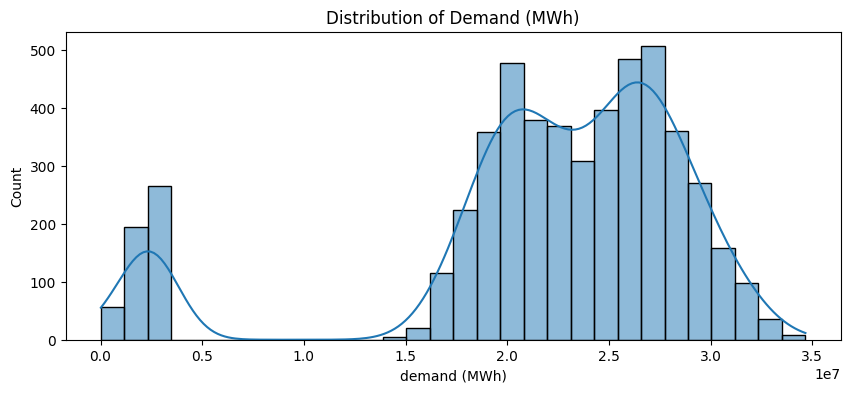

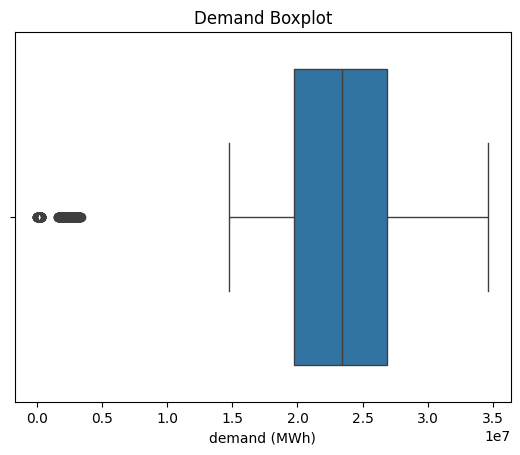

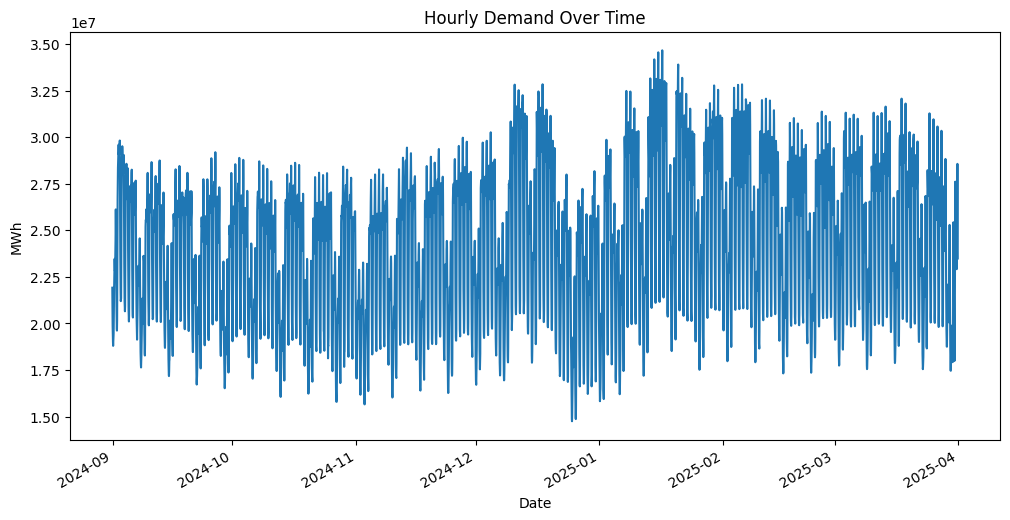

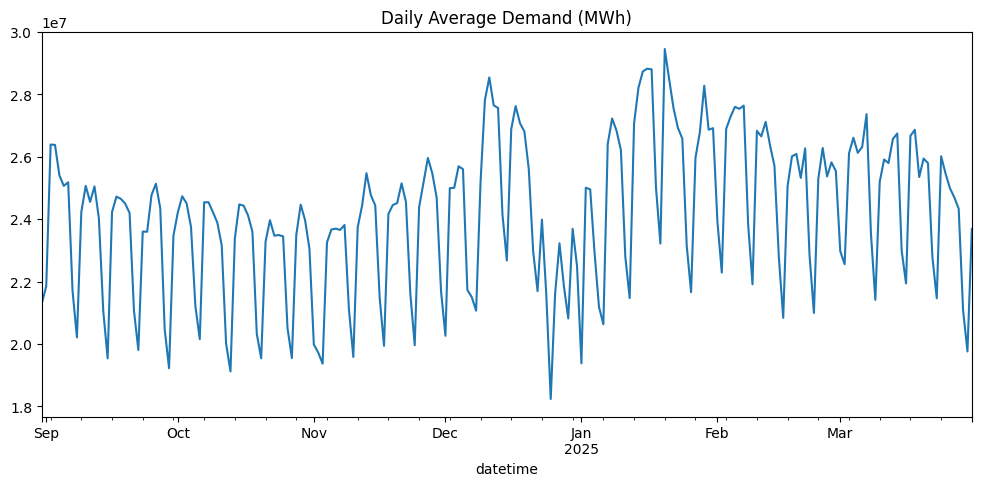

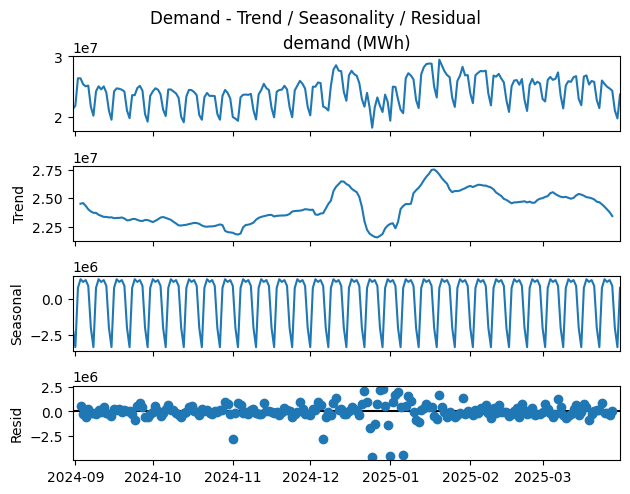

<Figure size 1000x500 with 0 Axes>

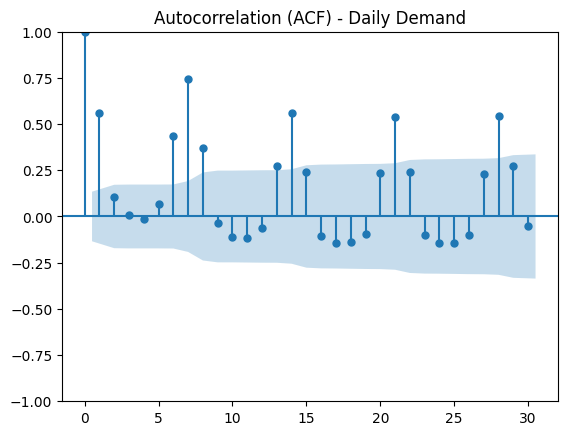

<Figure size 1000x500 with 0 Axes>

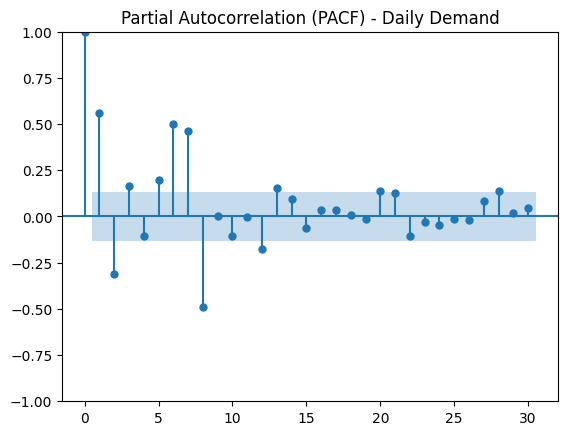

NA datetime: 0 Duplicates: 0
Missing hours: 0


C:\Users\davide\AppData\Local\Temp\ipykernel_21856\212101510.py:68: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(DemandaEnConsumo_indexed.index.min(),


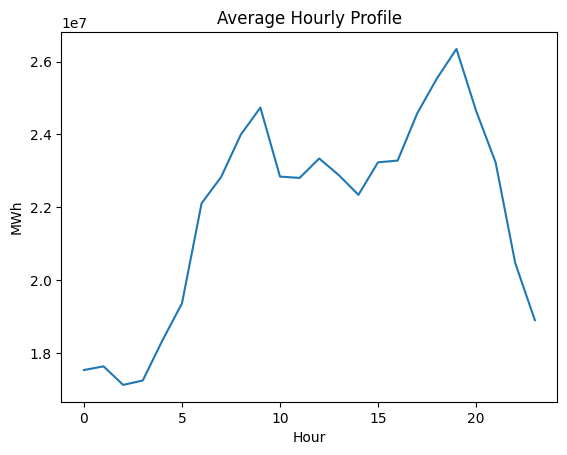

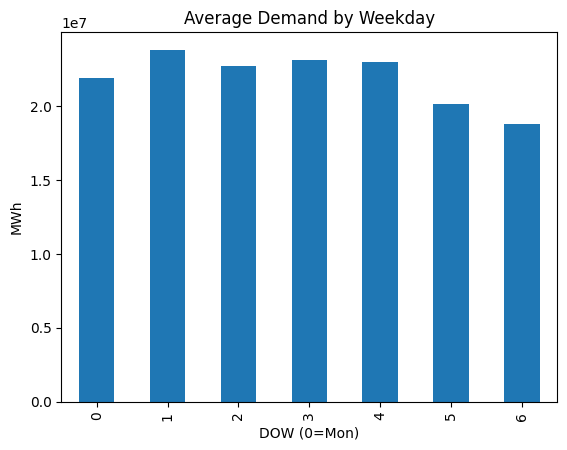

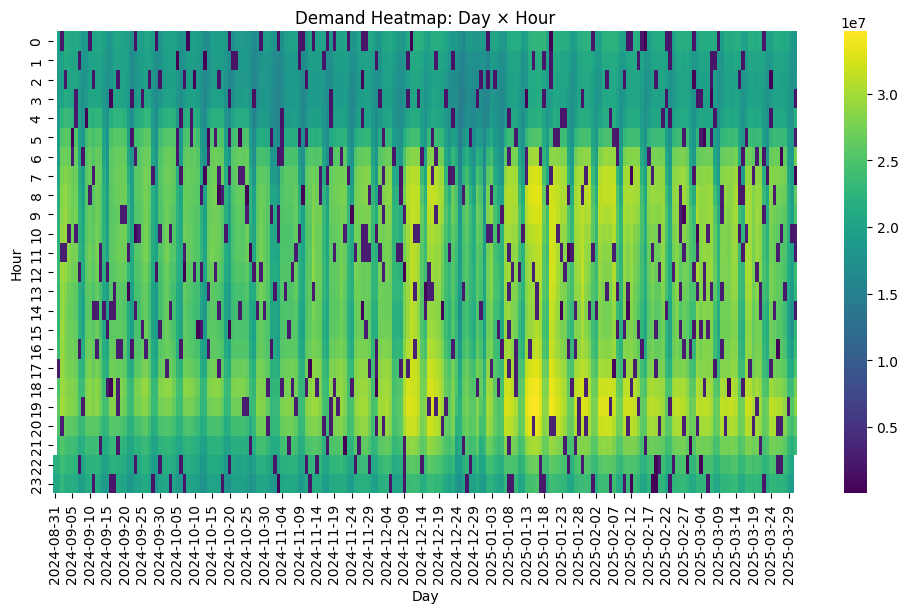

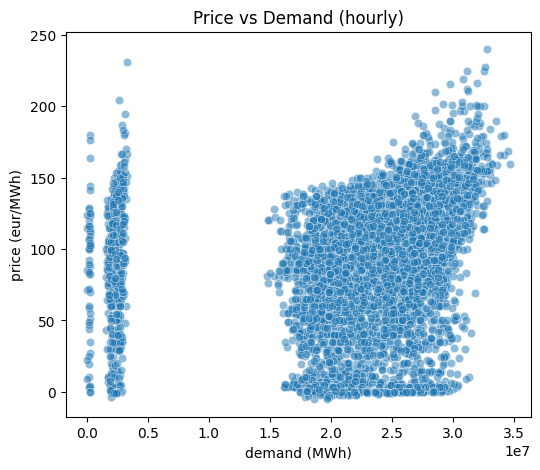

Correlation (Demand, Price):
                  demand (MWh)  price (eur/MWh)
demand (MWh)         1.000000         0.172798
price (eur/MWh)      0.172798         1.000000


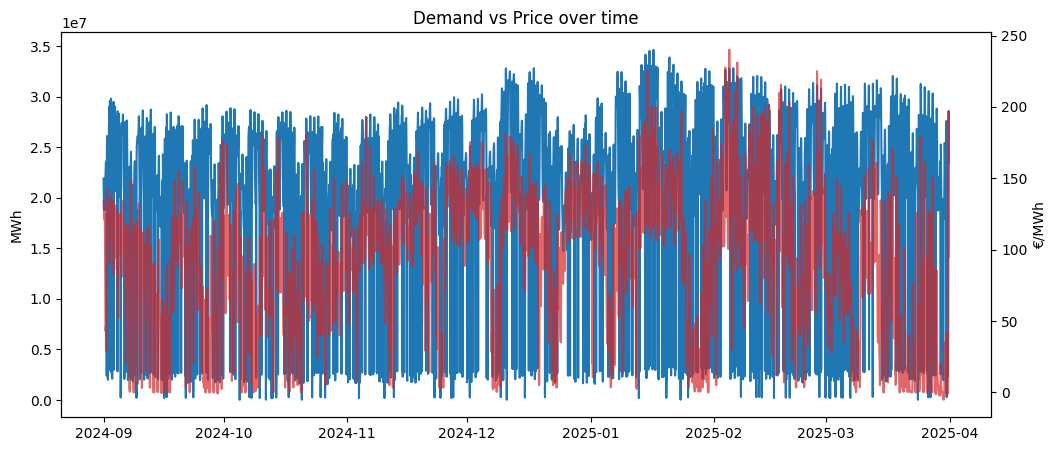

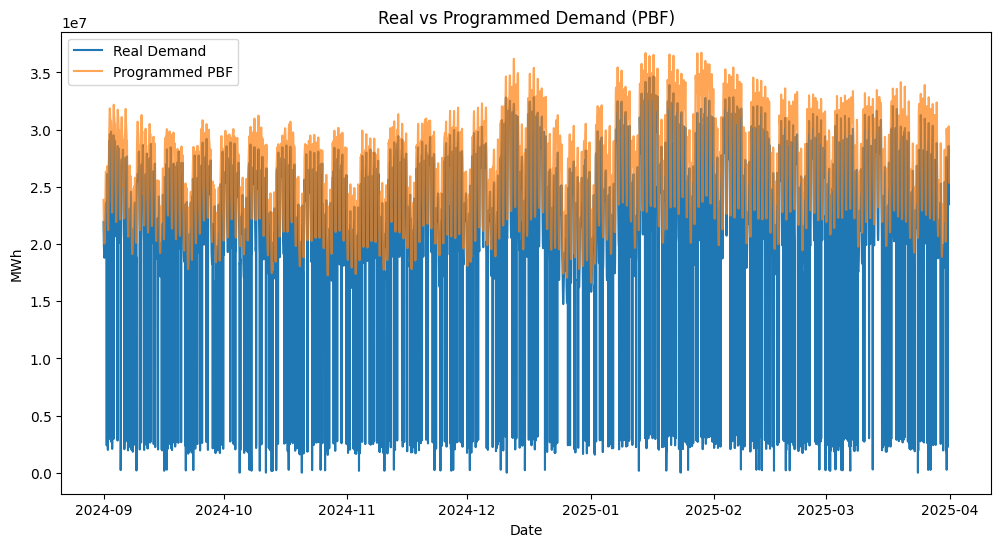

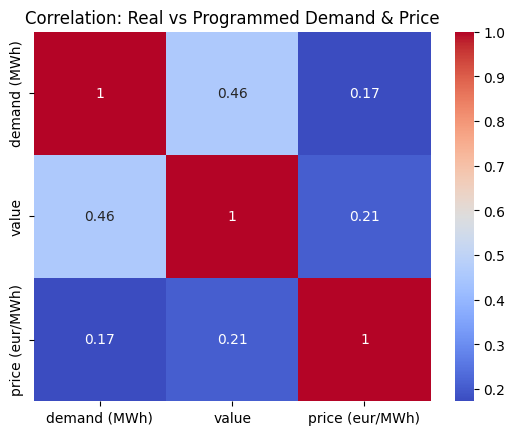

                     price (eur/MWh)  price_t-24  demand (MWh)  demand_t-24
datetime                                                                   
2024-08-31 22:00:00           134.02         NaN    21919561.0          NaN
2024-08-31 23:00:00           129.16         NaN    20683093.0          NaN
2024-09-01 00:00:00           125.92         NaN    19864012.0          NaN
2024-09-01 01:00:00           124.30         NaN    19326345.0          NaN
2024-09-01 02:00:00           122.68         NaN    19003285.0          NaN
2024-09-01 03:00:00           121.39         NaN    18798364.0          NaN
2024-09-01 04:00:00           124.09         NaN    19055217.0          NaN
2024-09-01 05:00:00           124.90         NaN    19212309.0          NaN
2024-09-01 06:00:00           113.08         NaN    19440639.0          NaN
2024-09-01 07:00:00           100.66         NaN    20410946.0          NaN
2024-09-01 08:00:00            78.50         NaN    21403825.0          NaN
2024-09-01 0

In [6]:

# ---------------------------
# 5) Basic stats & distributions
# ---------------------------
print(DemandaEnConsumo['demand (MWh)'].describe())

plt.figure(figsize=(10,4))
sns.histplot(DemandaEnConsumo['demand (MWh)'], bins=30, kde=True)
plt.title('Distribution of Demand (MWh)')
plt.show()

sns.boxplot(x=DemandaEnConsumo['demand (MWh)'])
plt.title("Demand Boxplot")
plt.show()

# ---------------------------
# 6) Outlier filter (IQR) for EDA plots only (do not alter original)
# ---------------------------
def remove_outliers_iqr(df, col):
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

clean = remove_outliers_iqr(DemandaEnConsumo, 'demand (MWh)').copy()
clean = clean.set_index('datetime').sort_index()

# ---------------------------
# 7) Time series plots (hourly, daily mean)
# ---------------------------
plt.figure(figsize=(12,6))
clean['demand (MWh)'].plot(color='tab:blue')
plt.title('Hourly Demand Over Time')
plt.xlabel('Date'); plt.ylabel('MWh')
plt.show()

daily = clean['demand (MWh)'].resample('D').mean().dropna()
daily.plot(figsize=(12,5), title='Daily Average Demand (MWh)')
plt.show()

# ---------------------------
# 8) Seasonal decomposition + ACF/PACF (daily)
# ---------------------------
decomp = seasonal_decompose(daily, period=7)
decomp.plot()
plt.suptitle('Demand - Trend / Seasonality / Residual', y=1.02)
plt.show()

plt.figure(figsize=(10,5))
plot_acf(daily, lags=30)
plt.title('Autocorrelation (ACF) - Daily Demand')
plt.show()

plt.figure(figsize=(10,5))
plot_pacf(daily, lags=30, method='ywm')
plt.title('Partial Autocorrelation (PACF) - Daily Demand')
plt.show()

# ---------------------------
# 9) Data quality: gaps & duplicates
# ---------------------------
# after set_index above, use DemandaEnConsumo_indexed for gap check
DemandaEnConsumo_indexed = DemandaEnConsumo.set_index('datetime').sort_index()

missing_dt = DemandaEnConsumo['datetime'].isna().sum()
dup_dt = DemandaEnConsumo.duplicated('datetime').sum()
print("NA datetime:", missing_dt, "Duplicates:", dup_dt)

full_idx = pd.date_range(DemandaEnConsumo_indexed.index.min(),
                         DemandaEnConsumo_indexed.index.max(), freq='H')
gap_idx = full_idx.difference(DemandaEnConsumo_indexed.index)
print("Missing hours:", len(gap_idx))

# ---------------------------
# 10) Hour/DOW profiles + heatmap
# ---------------------------
prof = DemandaEnConsumo_indexed.copy()
prof['Hour'] = prof.index.hour
prof['DOW']  = prof.index.dayofweek  # 0=Mon ... 6=Sun

hour_profile = prof.groupby('Hour')['demand (MWh)'].mean()
dow_profile  = prof.groupby('DOW')['demand (MWh)'].mean()

ax = hour_profile.plot(title='Average Hourly Profile'); plt.xlabel('Hour'); plt.ylabel('MWh'); plt.show()
ax = dow_profile.plot(kind='bar', title='Average Demand by Weekday'); plt.xlabel('DOW (0=Mon)'); plt.ylabel('MWh'); plt.show()

# Heatmap day x hour
tmp = prof.copy()
tmp['date'] = tmp.index.date
tmp['hour'] = tmp.index.hour
pvt = tmp.pivot_table(values='demand (MWh)', index='date', columns='hour', aggfunc='mean')
plt.figure(figsize=(12,6))
sns.heatmap(pvt.T, cmap='viridis')
plt.title('Demand Heatmap: Day × Hour'); plt.xlabel('Day'); plt.ylabel('Hour')
plt.show()

# ---------------------------
# 11) Price vs Demand (merge-based EDA)
# ---------------------------
merged_idx = merged.set_index('datetime').sort_index()

# scatter & correlation
plt.figure(figsize=(6,5))
sns.scatterplot(x='demand (MWh)', y='price (eur/MWh)', data=merged_idx.reset_index(), alpha=0.5)
plt.title('Price vs Demand (hourly)')
plt.show()

corr = merged_idx[['demand (MWh)', 'price (eur/MWh)']].corr()
print("Correlation (Demand, Price):\n", corr)

# parallel lines
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(merged_idx.index, merged_idx['demand (MWh)'], label='Demand (MWh)')
ax1.set_ylabel('MWh')
ax2 = ax1.twinx()
ax2.plot(merged_idx.index, merged_idx['price (eur/MWh)'], color='tab:red', alpha=0.7, label='Price (€/MWh)')
ax2.set_ylabel('€/MWh')
plt.title('Demand vs Price over time')
plt.show()


# --- Compare Real vs Programmed Demand ---
plt.figure(figsize=(12,6))
plt.plot(merged['datetime'], merged['demand (MWh)'], label='Real Demand', color='tab:blue')
plt.plot(merged['datetime'], merged['value'], label='Programmed PBF', color='tab:orange', alpha=0.7)
plt.title('Real vs Programmed Demand (PBF)')
plt.xlabel('Date'); plt.ylabel('MWh')
plt.legend()
plt.show()

# Correlation between real, programmed and price
corr = merged[['demand (MWh)', 'value', 'price (eur/MWh)']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation: Real vs Programmed Demand & Price')
plt.show()

# ---------------------------
# 12) (Optional) Lag features preview (for Task 2)
# ---------------------------
merged_lag = merged_idx.copy()
merged_lag['price_t-24'] = merged_lag['price (eur/MWh)'].shift(24)
merged_lag['demand_t-24'] = merged_lag['demand (MWh)'].shift(24)
print(merged_lag[['price (eur/MWh)','price_t-24','demand (MWh)','demand_t-24']].head(30))


CHECK FOR ANOMALIES (blackouts means really low values and anomalies in price

Anomalies detected (z-score > 3):
                     demand (MWh)  price (eur/MWh)       value  price_zscore
datetime                                                                    
2025-02-04 19:00:00    32806588.0            240.0  34795500.0      3.236759
2025-02-06 19:00:00     3279258.0            231.0  34806300.0      3.045668
Blackout days data:
Empty DataFrame
Columns: [demand (MWh), price (eur/MWh), value, price_zscore]
Index: []
Dataset starts on: 2024-08-31 22:00:00
Dataset ends on: 2025-03-31 21:00:00


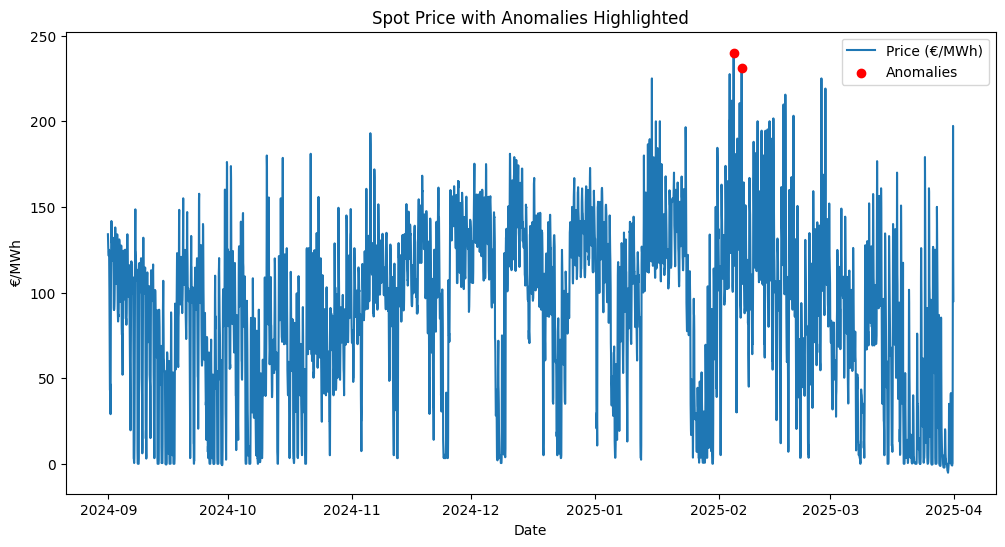

In [7]:
merged_idx.index = pd.to_datetime(merged_idx.index)

merged_idx['price_zscore'] = zscore(merged_idx['price (eur/MWh)'])
anomalies = merged_idx[merged_idx['price_zscore'].abs() > 3]

#identify blackout days
blackout_days = merged_idx[merged_idx['demand (MWh)'] < 10000]  # threshold for blackout in Spain (MWh)

print("Anomalies detected (z-score > 3):")
print(anomalies)
print("Blackout days data:")
print(blackout_days)

#check the first and last days of the dataset 
print("Dataset starts on:", merged_idx.index.min())
print("Dataset ends on:", merged_idx.index.max())

# plot anomalies and the full price series
plt.figure(figsize=(12,6))
plt.plot(merged_idx.index, merged_idx['price (eur/MWh)'], label='Price (€/MWh)')
plt.scatter(anomalies.index, anomalies['price (eur/MWh)'], color='red', label='Anomalies', zorder=5)
plt.title('Spot Price with Anomalies Highlighted')
plt.xlabel('Date'); plt.ylabel('€/MWh')
plt.legend()
plt.show()

# We can assume that those anomalies doesn't need to be removed, but just flagged.


# tell 

Input data range: 2024-08-31 22:00:00 to 2025-03-31 21:00:00
